# 将模型预测的参数值可视化出来

## 导入所有信息

### 导入依赖

In [52]:
import json
import os
import sys
import pickle

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()
sys.path.append(os.getenv("PROJ_PATH"))  # type: ignore

from dmg.core.post.plot_parameters import plot_parameters  # noqa
from project.better_estimate import load_config  # noqa

### 导入配置

In [53]:
config = load_config(r"conf/config_dhbv_tcn.yaml")
out_path = config["out_path"]

### 加载数据

In [54]:
from dmg.core.data.loaders import HydroLoader   # noqa

loader = HydroLoader(config, test_split=True, overwrite=False)
loader.load_dataset()
eval_dataset = loader.eval_dataset

### 加载流域ids

In [55]:
with open(os.path.join(os.getenv("DATA_PATH"), "531sub_id.txt"), "r") as f:
    selected_basins = np.array(json.load(f))

## 构建模型

In [56]:
from dmg import ModelHandler
from dmg.core.utils import import_trainer  # noqa

config["mode"] = "test"
config["test"]["test_epoch"] = 6
model = ModelHandler(config, verbose=True)
trainer_cls = import_trainer(config["trainer"])
trainer = trainer_cls(
    config,
    model,
    eval_dataset=eval_dataset,
    verbose=True,
)
nn_model = trainer.model.model_dict["Hbv_2"].nn_model
tcn_layer = nn_model.tcninv
ln_layer = nn_model.ln
fc_layer = nn_model.fc


def predict(x):
    tcn_out = tcn_layer(x.permute(1, 0, 2))
    tcn_out = ln_layer(tcn_out)
    fc_out = fc_layer(tcn_out.permute(1, 0, 2))
    return F.sigmoid(fc_out * nn_model.a)

## 得到模型输出结果

In [63]:
import torch

model_input = eval_dataset["xc_nn_norm"]
# select_basin_idx = np.where(selected_basins==8023080)[0][0]
select_basin_idx = 500
print(select_basin_idx)
tmp_model_input = model_input[730:4*730, select_basin_idx : select_basin_idx + 1, :]
print(model_input.shape)
layer_output = predict(tmp_model_input)
print(layer_output.shape)
layer_output = layer_output.reshape(-1, 3, 16)[:,:,:]
# layer_output = layer_output[:, :, :]
print(layer_output.shape)

500
torch.Size([5479, 531, 38])
torch.Size([2190, 1, 48])
torch.Size([2190, 3, 16])


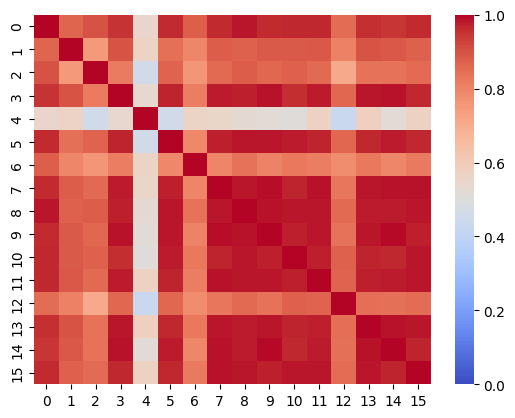

In [64]:
corr_matrix = np.corrcoef(layer_output.detach().cpu().numpy()[:,2,:], rowvar=False)

import seaborn as sns
import matplotlib.pyplot as plt

# 绘制相关性热图
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=0, vmax=1)
plt.show()

## 绘制模型预测结果

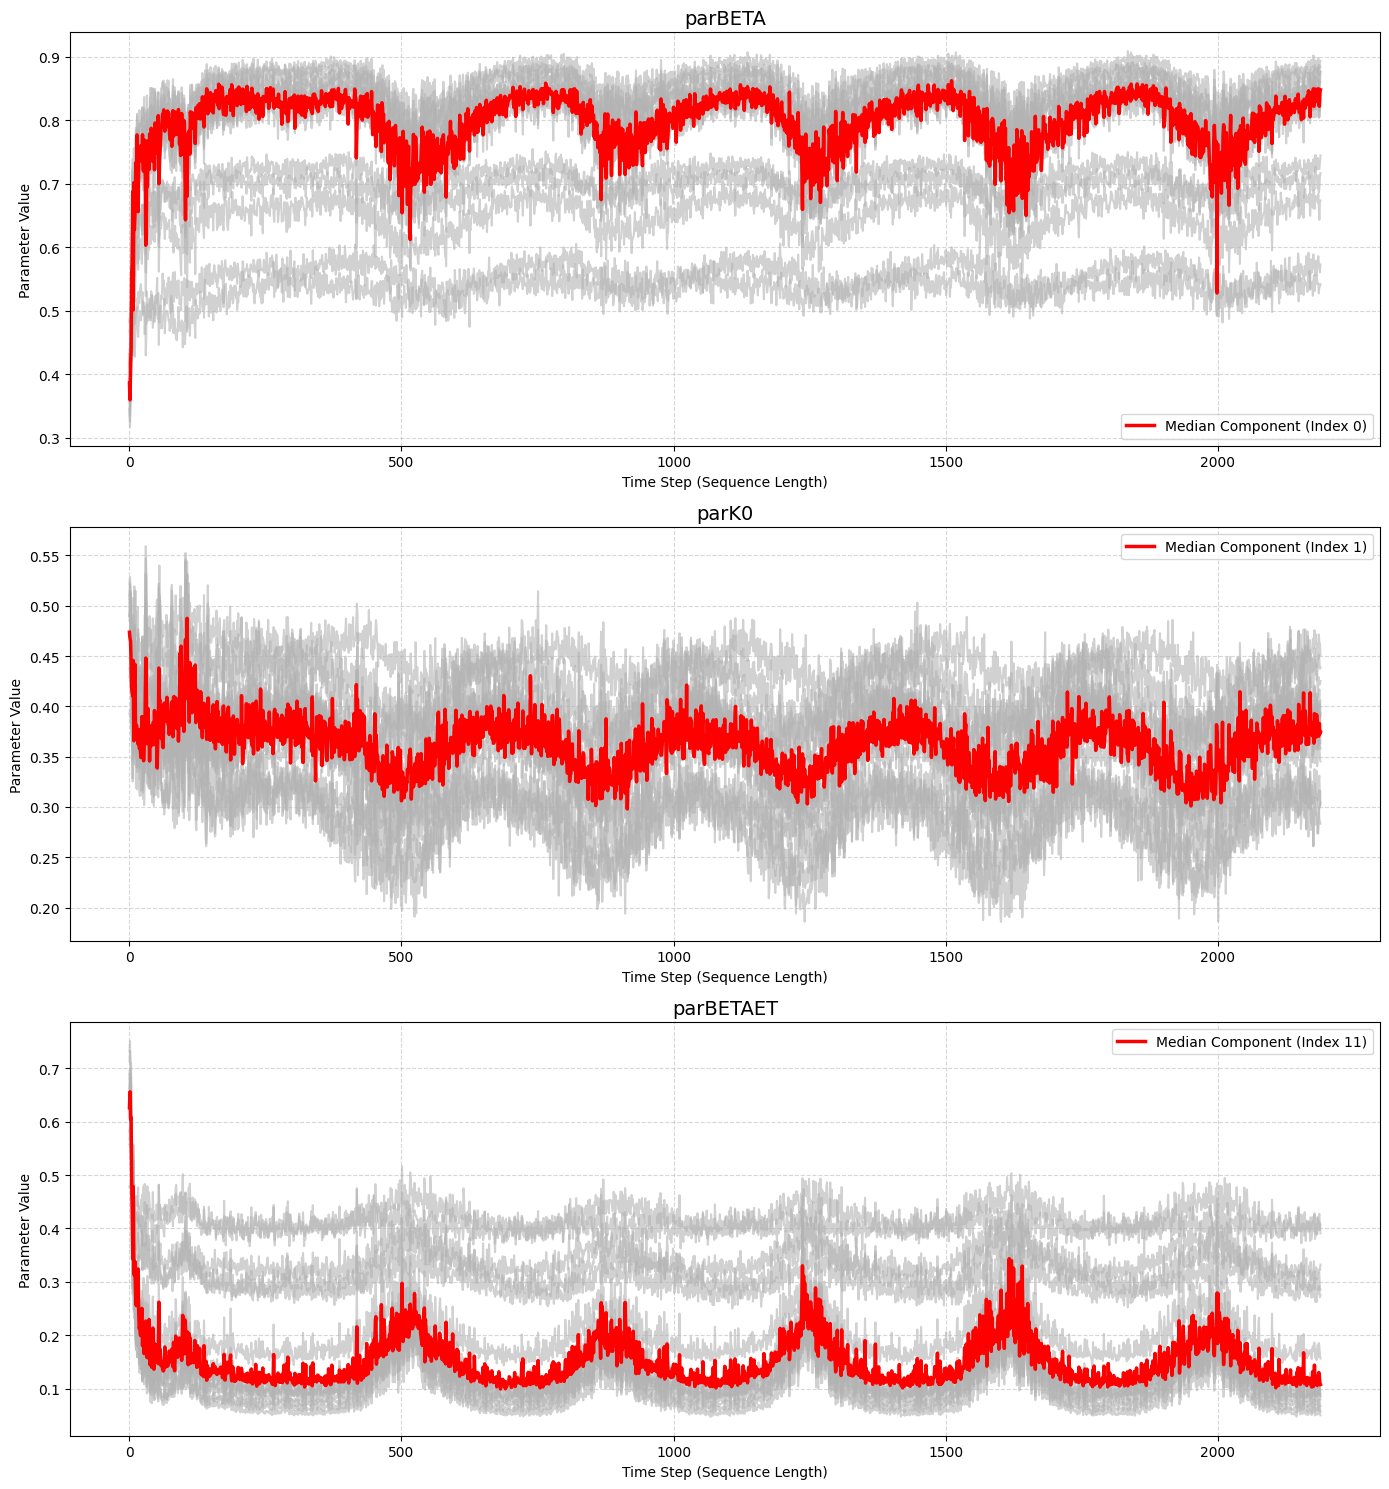

In [65]:
timevar_params = layer_output.detach().cpu().numpy()
titles = ['parBETA', 'parK0', 'parBETAET']
plot_parameters(timevar_params, titles=titles, median_color='red', smooth_window=1)
plt.show()